<a href="https://colab.research.google.com/github/NOUTAILAA/OCT2017/blob/main/OCT2017.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ETAPE 0 : configurer le notebook --- GPU T4

ÉTAPE 1 — Téléchargement le dataset avec kagglehub

In [ ]:
import kagglehub
import os

# Télécharger le dataset
path = kagglehub.dataset_download("paultimothymooney/kermany2018")

print("Dataset downloaded at:", path)
print("Content:", os.listdir(path))


Using Colab cache for faster access to the 'kermany2018' dataset.
Dataset downloaded at: /kaggle/input/kermany2018
Content: ['OCT2017 ', 'oct2017']


ÉTAPE 2 — Définition les chemins vers train/val/test

In [ ]:
DATA_DIR = os.path.join(path, "OCT2017 ")

print("OCT2017 folder:", DATA_DIR)
print("Subfolders:", os.listdir(DATA_DIR))

train_dir = os.path.join(DATA_DIR, "train")
val_dir   = os.path.join(DATA_DIR, "val")
test_dir  = os.path.join(DATA_DIR, "test")

print("Train path:", train_dir)
print("Val path:", val_dir)
print("Test path:", test_dir)


OCT2017 folder: /kaggle/input/kermany2018/OCT2017 
Subfolders: ['val', 'test', 'train']
Train path: /kaggle/input/kermany2018/OCT2017 /train
Val path: /kaggle/input/kermany2018/OCT2017 /val
Test path: /kaggle/input/kermany2018/OCT2017 /test


ÉTAPE 3 — Préparation du dataset

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

BATCH_SIZE = 32
IMAGE_SIZE = 224

train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset   = datasets.ImageFolder(val_dir,   transform=val_test_transforms)
test_dataset  = datasets.ImageFolder(test_dir,  transform=val_test_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print("Classes:", train_dataset.classes)
print("Train samples:", len(train_dataset))
print("Val samples:", len(val_dataset))
print("Test samples:", len(test_dataset))


Classes: ['CNV', 'DME', 'DRUSEN', 'NORMAL']
Train samples: 83484
Val samples: 32
Test samples: 968


ÉTAPE 4 — Création du modèle CNN

In [ ]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Remplacement de la dernière couche
model.fc = nn.Linear(model.fc.in_features, 4)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


Device: cuda
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 100MB/s] 


ÉTAPE 5 — Fonction d'entraînement

In [ ]:
import time
import copy

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    best_acc = 0.0
    best_weights = copy.deepcopy(model.state_dict())

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        print("-" * 30)

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
                loader = train_loader
            else:
                model.eval()
                loader = val_loader

            running_loss = 0.0
            running_correct = 0
            total = 0

            for inputs, labels in loader:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = outputs.max(1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_correct += (preds == labels).sum().item()
                total += inputs.size(0)

            epoch_loss = running_loss / total
            epoch_acc = running_correct / total

            print(f"{phase} Loss: {epoch_loss:.4f}  Acc: {epoch_acc:.4f}")

            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_weights = copy.deepcopy(model.state_dict())

    print("\nBest validation accuracy:", best_acc)
    model.load_state_dict(best_weights)
    return model


ÉTAPE 6 — Entraînement du modèle

In [ ]:
model = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5)





Epoch 1/5
------------------------------
train Loss: 0.1297  Acc: 0.9564
val Loss: 0.0124  Acc: 1.0000

Epoch 2/5
------------------------------
train Loss: 0.1063  Acc: 0.9638
val Loss: 0.0076  Acc: 1.0000

Epoch 3/5
------------------------------
train Loss: 0.0946  Acc: 0.9678
val Loss: 0.0214  Acc: 1.0000

Epoch 4/5
------------------------------
train Loss: 0.0870  Acc: 0.9702
val Loss: 0.0117  Acc: 1.0000

Epoch 5/5
------------------------------
train Loss: 0.0769  Acc: 0.9731
val Loss: 0.0053  Acc: 1.0000

Best validation accuracy: 1.0


In [ ]:
torch.save(model.state_dict(), "resnet18_oct_best.pth")
print("Model saved in current directory!")


Model saved in current directory!


In [ ]:
from google.colab import files
files.download("resnet18_oct_best.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

ÉTAPE 7 — Test le modèle

In [ ]:
def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = outputs.max(1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return correct / total

test_acc = evaluate(model, test_loader)
print("Test accuracy:", test_acc)


Test accuracy: 0.9896694214876033


**TESTER AVEC UNE IMAGE EN LOCAL**






**CAS DU DRUSEN**

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving DRUSEN.jpeg to DRUSEN (1).jpeg


Image test : DRUSEN (1).jpeg


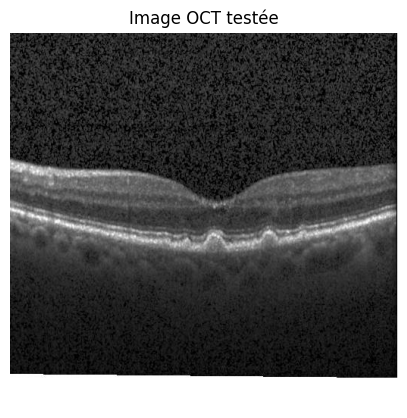


Prediction : DRUSEN


In [ ]:
from PIL import Image
from torchvision import transforms
import torch
import matplotlib.pyplot as plt

IMAGE_SIZE = 224

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Device du modèle
device = next(model.parameters()).device

# Image uploadée
img_path = list(uploaded.keys())[0]
print("Image test :", img_path)

# Charger l'image
img = Image.open(img_path)

# --- AFFICHAGE DE L’IMAGE ---
plt.figure(figsize=(5,5))
plt.imshow(img, cmap="gray")
plt.title("Image OCT testée")
plt.axis("off")
plt.show()

# Préparation pour le modèle
input_tensor = transform(img).unsqueeze(0).to(device)

# Prédiction
model.eval()
with torch.no_grad():
    outputs = model(input_tensor)
    _, predicted = torch.max(outputs, 1)

# Classes
class_names = ["CNV", "DME", "DRUSEN", "NORMAL"]

print("\nPrediction :", class_names[predicted.item()])


**CAS Du DME **

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving DME-1102486-3.jpg to DME-1102486-3.jpg


Image test : DME-1102486-3.jpg


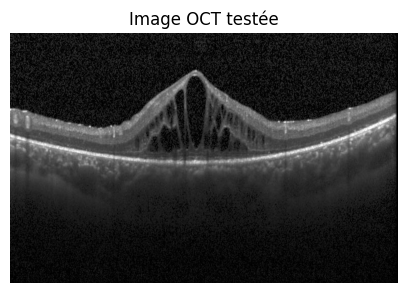


Prediction : Diabetic Macular Edema (DME)


In [ ]:
from PIL import Image
from torchvision import transforms
import torch
import matplotlib.pyplot as plt

IMAGE_SIZE = 224

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Device du modèle
device = next(model.parameters()).device

# Image uploadée
img_path = list(uploaded.keys())[0]
print("Image test :", img_path)

# Charger l'image
img = Image.open(img_path)

# --- AFFICHAGE DE L’IMAGE ---
plt.figure(figsize=(5,5))
plt.imshow(img, cmap="gray")
plt.title("Image OCT testée")
plt.axis("off")
plt.show()

# Préparation pour le modèle
input_tensor = transform(img).unsqueeze(0).to(device)

# Prédiction
model.eval()
with torch.no_grad():
    outputs = model(input_tensor)
    _, predicted = torch.max(outputs, 1)

# Noms COMPLETS des pathologies
class_names = [
    "Choroidal Neovascularization (CNV)",
    "Diabetic Macular Edema (DME)",
    "Drusen - Age-related Macular Degeneration (DRUSEN)",
    "Normal Retina"
]

print("\nPrediction :", class_names[predicted.item()])
